#### Importing Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import csv
import klib
import seaborn as sns
import matplotlib.pyplot as plt
import os


from sklearn import svm
from sklearn.ensemble  import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

#### Importing Data

In [2]:
file_path = os.path.dirname(os.path.abspath("training_validation_insertion"))
data=pd.read_csv(file_path +'\\Data\\input.csv')
data.head()

months_as_customer  age  policy_number policy_bind_date policy_state  \
0                 328   48         521585       10/17/2014           OH   
1                 228   42         342868        6/27/2006           IN   
2                 134   29         687698         9/6/2000           OH   
3                 256   41         227811        5/25/1990           IL   
4                 228   44         367455         6/6/2014           IL   

  policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
0    250/500               1000                1406.91               0   
1    250/500               2000                1197.22         5000000   
2    100/300               2000                1413.14         5000000   
3    250/500               2000                1415.74         6000000   
4   500/1000               1000                1583.91         6000000   

   insured_zip  ... witnesses police_report_available total_claim_amount  \
0       466132  ...         2                     YES              71610   
1       468176  ...         0                       ?               5070   
2       430632  ...         3                      NO              34650   
3       608117  ...         2                      NO              63400   
4       610706  ...         1                      NO               6500   

  injury_claim property_claim  vehicle_claim  auto_make auto_model auto_year  \
0         6510          13020          52080       Saab        92x      2004   
1          780            780           3510   Mercedes       E400      2007   
2         7700           3850          23100      Dodge        RAM      2007   
3         6340           6340          50720  Chevrolet      Tahoe      2014   
4         1300            650           4550     Accura        RSX      2009   

  fraud_reported  
0              Y  
1              Y  
2              N  
3              Y  
4              N  

[5 rows x 39 columns]

In [3]:
len(data)

1000

##### Looking for columns with constant values

In [4]:
data.columns[data.nunique() <= 1]

Index([], dtype='object')

##### Removing fields which may not be relevant to a case of insurance fraud
We would like to exclude these fields becuase none of these fields will influence a customer from commiting a fraud. For example a Policy state of a customer has nothing to do with the customer committing an insurance fraud, the customer may do the same fraud in any state. So the fields we think are not relevant are
1) policy_number
2) policy_bind_date
3) policy_state
4) insured_zip
5) insured_hobbies
6) incident_state	
7) incident_city	
8) auto_make	
9) auto_model	
10) auto_year




In [5]:
cols_to_drop = ['policy_number','policy_bind_date','policy_state','insured_zip','incident_location','incident_date','incident_state','incident_city','insured_hobbies','auto_make','auto_model','auto_year']

In [6]:
data.drop(columns=cols_to_drop,inplace=True)

In [7]:
data.head()

months_as_customer  age policy_csl  policy_deductable  \
0                 328   48    250/500               1000   
1                 228   42    250/500               2000   
2                 134   29    100/300               2000   
3                 256   41    250/500               2000   
4                 228   44   500/1000               1000   

   policy_annual_premium  umbrella_limit insured_sex insured_education_level  \
0                1406.91               0        MALE                      MD   
1                1197.22         5000000        MALE                      MD   
2                1413.14         5000000      FEMALE                     PhD   
3                1415.74         6000000      FEMALE                     PhD   
4                1583.91         6000000        MALE               Associate   

  insured_occupation insured_relationship  ...  number_of_vehicles_involved  \
0       craft-repair              husband  ...                            1   
1  machine-op-inspct       other-relative  ...                            1   
2              sales            own-child  ...                            3   
3       armed-forces            unmarried  ...                            1   
4              sales            unmarried  ...                            1   

   property_damage bodily_injuries witnesses police_report_available  \
0              YES               1         2                     YES   
1                ?               0         0                       ?   
2               NO               2         3                      NO   
3                ?               1         2                      NO   
4               NO               0         1                      NO   

  total_claim_amount  injury_claim  property_claim vehicle_claim  \
0              71610          6510           13020         52080   
1               5070           780             780          3510   
2              34650          7700            3850         23100   
3              63400          6340            6340         50720   
4               6500          1300             650          4550   

   fraud_reported  
0               Y  
1               Y  
2               N  
3               Y  
4               N  

[5 rows x 27 columns]

##### Replacing ? with NaN

In [8]:
data.replace("?",np.NaN, inplace = True)

##### Splitting Necessary columns

In [9]:
data['policy_csl_used'] = data['policy_csl'].str.split('/').str[0].astype(int)
data['policy_csl_used_available'] = data['policy_csl'].str.split('/').str[1].astype(int)

In [10]:
data.drop(columns='policy_csl',inplace=True)


In [11]:
data.head()

months_as_customer  age  policy_deductable  policy_annual_premium  \
0                 328   48               1000                1406.91   
1                 228   42               2000                1197.22   
2                 134   29               2000                1413.14   
3                 256   41               2000                1415.74   
4                 228   44               1000                1583.91   

   umbrella_limit insured_sex insured_education_level insured_occupation  \
0               0        MALE                      MD       craft-repair   
1         5000000        MALE                      MD  machine-op-inspct   
2         5000000      FEMALE                     PhD              sales   
3         6000000      FEMALE                     PhD       armed-forces   
4         6000000        MALE               Associate              sales   

  insured_relationship  capital_gains  ...  bodily_injuries witnesses  \
0              husband          53300  ...                1         2   
1       other-relative              0  ...                0         0   
2            own-child          35100  ...                2         3   
3            unmarried          48900  ...                1         2   
4            unmarried          66000  ...                0         1   

  police_report_available total_claim_amount injury_claim  property_claim  \
0                     YES              71610         6510           13020   
1                     NaN               5070          780             780   
2                      NO              34650         7700            3850   
3                      NO              63400         6340            6340   
4                      NO               6500         1300             650   

   vehicle_claim fraud_reported  policy_csl_used  policy_csl_used_available  
0          52080              Y              250                        500  
1           3510              Y              250                        500  
2          23100              N              100                        300  
3          50720              Y              250                        500  
4           4550              N              500                       1000  

[5 rows x 28 columns]

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_deductable            1000 non-null   int64  
 3   policy_annual_premium        1000 non-null   float64
 4   umbrella_limit               1000 non-null   int64  
 5   insured_sex                  1000 non-null   object 
 6   insured_education_level      1000 non-null   object 
 7   insured_occupation           1000 non-null   object 
 8   insured_relationship         1000 non-null   object 
 9   capital_gains                1000 non-null   int64  
 10  capital_loss                 1000 non-null   int64  
 11  incident_type                1000 non-null   object 
 12  collision_type               822 non-null    object 
 13  incident_severity  

##### Checking for null values

In [13]:
data.isnull().sum()

months_as_customer               0
age                              0
policy_deductable                0
policy_annual_premium            0
umbrella_limit                   0
insured_sex                      0
insured_education_level          0
insured_occupation               0
insured_relationship             0
capital_gains                    0
capital_loss                     0
incident_type                    0
collision_type                 178
incident_severity                0
authorities_contacted            0
incident_hour_of_the_day         0
number_of_vehicles_involved      0
property_damage                360
bodily_injuries                  0
witnesses                        0
police_report_available        343
total_claim_amount               0
injury_claim                     0
property_claim                   0
vehicle_claim                    0
fraud_reported                   0
policy_csl_used                  0
policy_csl_used_available        0
dtype: int64

In [14]:
[col for col in data.columns if data[col].isnull(). any()]

['collision_type', 'property_damage', 'police_report_available']

In [15]:

cat_cols = [col for col in data.columns if data[col].dtypes == 'O']

In [16]:
num_cols = [col for col in data.columns if data[col].dtypes != 'O']

In [17]:
cat_cols

['insured_sex',
 'insured_education_level',
 'insured_occupation',
 'insured_relationship',
 'incident_type',
 'collision_type',
 'incident_severity',
 'authorities_contacted',
 'property_damage',
 'police_report_available',
 'fraud_reported']

Out of the available categorical variables, the variables below are ordinal variables with respect to the abilty to committ fraud

1) insured_sex
2) insured_education_level
3) incident_severity
4) property_damage
5) police_report_available
6) fraud_reported
7) policy_csl

I chose manual encoding over SK learns labelencoding  because I wanted to rank the values manually

In [18]:
print("Categorical Variables before Label Encoding")
print(data['insured_sex'].unique())
print(data['insured_education_level'].unique())
print(data['incident_severity'].unique())
print(data['property_damage'].unique())
print(data['police_report_available'].unique())
print(data['fraud_reported'].unique())
print(data['collision_type'].unique())


# custom mapping for encoding
data['insured_education_level'] = data['insured_education_level'].map({'JD' : 1, 'High School' : 2,'College':3,'Masters':4,'Associate':5,'MD':6,'PhD':7})
data['incident_severity'] = data['incident_severity'].map({'Trivial Damage' : 1, 'Minor Damage' : 2,'Major Damage':3,'Total Loss':4})
data['insured_sex'] = data['insured_sex'].map({'FEMALE' : 0, 'MALE' : 1})
data['property_damage'] = data['property_damage'].map({'NO' : 0, 'YES' : 1})
data['police_report_available'] = data['police_report_available'].map({'NO' : 0, 'YES' : 1})
data['fraud_reported'] = data['fraud_reported'].map({'N' : 0, 'Y' : 1})
data['collision_type'] = data['collision_type'].map({'Side Collision' : 0, 'Rear Collision' : 1, 'Front Collision' : 2})


print("Categorical Variables after Label Encoding")
print(data['insured_sex'].unique())
print(data['insured_education_level'].unique())
print(data['incident_severity'].unique())
print(data['property_damage'].unique())
print(data['police_report_available'].unique())
print(data['fraud_reported'].unique())
print(data['collision_type'].unique())


Categorical Variables before Label Encoding
['MALE' 'FEMALE']
['MD' 'PhD' 'Associate' 'Masters' 'High School' 'College' 'JD']
['Major Damage' 'Minor Damage' 'Total Loss' 'Trivial Damage']
['YES' nan 'NO']
['YES' nan 'NO']
['Y' 'N']
['Side Collision' nan 'Rear Collision' 'Front Collision']
Categorical Variables after Label Encoding
[1 0]
[6 7 5 4 2 3 1]
[3 2 4 1]
[ 1. nan  0.]
[ 1. nan  0.]
[1 0]
[ 0. nan  1.  2.]


Out of the available categorical variables, the variables below are non-ordinal variables with respect to the abilty to committ fraud. We will perform one hot encoding on them.

1) authorities_contacted
2) incident_type
3) insured_relationship
4) insured_occupation
5) collision_type

In [19]:
print("Categorical Variables before One hot Encoding")
print(data['authorities_contacted'].unique())
print(data['incident_type'].unique())
print(data['insured_relationship'].unique())
print(data['insured_occupation'].unique())
print(data['collision_type'].unique())

data = pd.get_dummies(data, columns=['authorities_contacted'], prefix = ['ac'], drop_first=True)
data = pd.get_dummies(data, columns=['incident_type'], prefix = ['it'], drop_first=True)
data = pd.get_dummies(data, columns=['insured_relationship'], prefix = ['ir'], drop_first=True)
data = pd.get_dummies(data, columns=['insured_occupation'], prefix = ['io'], drop_first=True)
    

Categorical Variables before One hot Encoding
['Police' 'None' 'Fire' 'Other' 'Ambulance']
['Single Vehicle Collision' 'Vehicle Theft' 'Multi-vehicle Collision'
 'Parked Car']
['husband' 'other-relative' 'own-child' 'unmarried' 'wife' 'not-in-family']
['craft-repair' 'machine-op-inspct' 'sales' 'armed-forces' 'tech-support'
 'prof-specialty' 'other-service' 'priv-house-serv' 'exec-managerial'
 'protective-serv' 'transport-moving' 'handlers-cleaners' 'adm-clerical'
 'farming-fishing']
[ 0. nan  1.  2.]


In [20]:
data

months_as_customer  age  policy_deductable  policy_annual_premium  \
0                   328   48               1000                1406.91   
1                   228   42               2000                1197.22   
2                   134   29               2000                1413.14   
3                   256   41               2000                1415.74   
4                   228   44               1000                1583.91   
..                  ...  ...                ...                    ...   
995                   3   38               1000                1310.80   
996                 285   41               1000                1436.79   
997                 130   34                500                1383.49   
998                 458   62               2000                1356.92   
999                 456   60               1000                 766.19   

     umbrella_limit  insured_sex  insured_education_level  capital_gains  \
0                 0            1                        6          53300   
1           5000000            1                        6              0   
2           5000000            0                        7          35100   
3           6000000            0                        7          48900   
4           6000000            1                        5          66000   
..              ...          ...                      ...            ...   
995               0            0                        4              0   
996               0            0                        7          70900   
997         3000000            0                        4          35100   
998         5000000            1                        5              0   
999               0            0                        5              0   

     capital_loss  collision_type  ...  io_farming-fishing  \
0               0             0.0  ...                   0   
1               0             NaN  ...                   0   
2               0             1.0  ...                   0   
3          -62400             2.0  ...                   0   
4          -46000             NaN  ...                   0   
..            ...             ...  ...                 ...   
995             0             2.0  ...                   0   
996             0             1.0  ...                   0   
997             0             0.0  ...                   0   
998             0             1.0  ...                   0   
999             0             NaN  ...                   0   

     io_handlers-cleaners  io_machine-op-inspct  io_other-service  \
0                       0                     0                 0   
1                       0                     1                 0   
2                       0                     0                 0   
3                       0                     0                 0   
4                       0                     0                 0   
..                    ...                   ...               ...   
995                     0                     0                 0   
996                     0                     0                 0   
997                     0                     0                 0   
998                     1                     0                 0   
999                     0                     0                 0   

     io_priv-house-serv  io_prof-specialty  io_protective-serv  io_sales  \
0                     0                  0                   0         0   
1                     0                  0                   0         0   
2                     0                  0                   0         1   
3                     0                  0                   0         0   
4                     0                  0                   0         1   
..                  ...                ...                 ...       ...   
995                   0                  0                   0         0   
996                  

In [21]:
data.isnull().sum()

months_as_customer               0
age                              0
policy_deductable                0
policy_annual_premium            0
umbrella_limit                   0
insured_sex                      0
insured_education_level          0
capital_gains                    0
capital_loss                     0
collision_type                 178
incident_severity                0
incident_hour_of_the_day         0
number_of_vehicles_involved      0
property_damage                360
bodily_injuries                  0
witnesses                        0
police_report_available        343
total_claim_amount               0
injury_claim                     0
property_claim                   0
vehicle_claim                    0
fraud_reported                   0
policy_csl_used                  0
policy_csl_used_available        0
ac_Fire                          0
ac_None                          0
ac_Other                         0
ac_Police                        0
it_Parked Car       

In [22]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=1)
data_imputed = imputer.fit_transform(data)
data_imputed = pd.DataFrame(data_imputed)
data_imputed

0     1       2        3          4    5    6        7        8    9   \
0    328.0  48.0  1000.0  1406.91        0.0  1.0  6.0  53300.0      0.0  0.0   
1    228.0  42.0  2000.0  1197.22  5000000.0  1.0  6.0      0.0      0.0  0.0   
2    134.0  29.0  2000.0  1413.14  5000000.0  0.0  7.0  35100.0      0.0  1.0   
3    256.0  41.0  2000.0  1415.74  6000000.0  0.0  7.0  48900.0 -62400.0  2.0   
4    228.0  44.0  1000.0  1583.91  6000000.0  1.0  5.0  66000.0 -46000.0  0.0   
..     ...   ...     ...      ...        ...  ...  ...      ...      ...  ...   
995    3.0  38.0  1000.0  1310.80        0.0  0.0  4.0      0.0      0.0  2.0   
996  285.0  41.0  1000.0  1436.79        0.0  0.0  7.0  70900.0      0.0  1.0   
997  130.0  34.0   500.0  1383.49  3000000.0  0.0  4.0  35100.0      0.0  0.0   
998  458.0  62.0  2000.0  1356.92  5000000.0  1.0  5.0      0.0      0.0  1.0   
999  456.0  60.0  1000.0   766.19        0.0  0.0  5.0      0.0      0.0  1.0   

     ...   39   40   41   42   43   44   45   46   47   48  
0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1    ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
3    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
995  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
996  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  
997  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
998  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
999  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  

[1000 rows x 49 columns]

In [23]:
data_columns = list(data.columns)
data_imputed.columns = data_columns

In [24]:
data

months_as_customer  age  policy_deductable  policy_annual_premium  \
0                   328   48               1000                1406.91   
1                   228   42               2000                1197.22   
2                   134   29               2000                1413.14   
3                   256   41               2000                1415.74   
4                   228   44               1000                1583.91   
..                  ...  ...                ...                    ...   
995                   3   38               1000                1310.80   
996                 285   41               1000                1436.79   
997                 130   34                500                1383.49   
998                 458   62               2000                1356.92   
999                 456   60               1000                 766.19   

     umbrella_limit  insured_sex  insured_education_level  capital_gains  \
0                 0            1                        6          53300   
1           5000000            1                        6              0   
2           5000000            0                        7          35100   
3           6000000            0                        7          48900   
4           6000000            1                        5          66000   
..              ...          ...                      ...            ...   
995               0            0                        4              0   
996               0            0                        7          70900   
997         3000000            0                        4          35100   
998         5000000            1                        5              0   
999               0            0                        5              0   

     capital_loss  collision_type  ...  io_farming-fishing  \
0               0             0.0  ...                   0   
1               0             NaN  ...                   0   
2               0             1.0  ...                   0   
3          -62400             2.0  ...                   0   
4          -46000             NaN  ...                   0   
..            ...             ...  ...                 ...   
995             0             2.0  ...                   0   
996             0             1.0  ...                   0   
997             0             0.0  ...                   0   
998             0             1.0  ...                   0   
999             0             NaN  ...                   0   

     io_handlers-cleaners  io_machine-op-inspct  io_other-service  \
0                       0                     0                 0   
1                       0                     1                 0   
2                       0                     0                 0   
3                       0                     0                 0   
4                       0                     0                 0   
..                    ...                   ...               ...   
995                     0                     0                 0   
996                     0                     0                 0   
997                     0                     0                 0   
998                     1                     0                 0   
999                     0                     0                 0   

     io_priv-house-serv  io_prof-specialty  io_protective-serv  io_sales  \
0                     0                  0                   0         0   
1                     0                  0                   0         0   
2                     0                  0                   0         1   
3                     0                  0                   0         0   
4                     0                  0                   0         1   
..                  ...                ...                 ...       ...   
995                   0                  0                   0         0   
996                  

In [25]:
data == data_imputed

months_as_customer   age  policy_deductable  policy_annual_premium  \
0                  True  True               True                   True   
1                  True  True               True                   True   
2                  True  True               True                   True   
3                  True  True               True                   True   
4                  True  True               True                   True   
..                  ...   ...                ...                    ...   
995                True  True               True                   True   
996                True  True               True                   True   
997                True  True               True                   True   
998                True  True               True                   True   
999                True  True               True                   True   

     umbrella_limit  insured_sex  insured_education_level  capital_gains  \
0              True         True                     True           True   
1              True         True                     True           True   
2              True         True                     True           True   
3              True         True                     True           True   
4              True         True                     True           True   
..              ...          ...                      ...            ...   
995            True         True                     True           True   
996            True         True                     True           True   
997            True         True                     True           True   
998            True         True                     True           True   
999            True         True                     True           True   

     capital_loss  collision_type  ...  io_farming-fishing  \
0            True            True  ...                True   
1            True           False  ...                True   
2            True            True  ...                True   
3            True            True  ...                True   
4            True           False  ...                True   
..            ...             ...  ...                 ...   
995          True            True  ...                True   
996          True            True  ...                True   
997          True            True  ...                True   
998          True            True  ...                True   
999          True           False  ...                True   

     io_handlers-cleaners  io_machine-op-inspct  io_other-service  \
0                    True                  True              True   
1                    True                  True              True   
2                    True                  True              True   
3                    True                  True              True   
4                    True                  True              True   
..                    ...                   ...               ...   
995                  True                  True              True   
996                  True                  True              True   
997                  True                  True              True   
998                  True                  True              True   
999                  True                  True              True   

     io_priv-house-serv  io_prof-specialty  io_protective-serv  io_sales  \
0                  True               True                True      True   
1                  True               True                True      True   
2                  True               True                True      True   
3                  True               True                True      True   
4                  True               True                True      True   
..                  ...                ...                 ...       ...   
995                True               True                True      True   
996      

In [26]:
data_imputed.isnull().sum()

months_as_customer             0
age                            0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_sex                    0
insured_education_level        0
capital_gains                  0
capital_loss                   0
collision_type                 0
incident_severity              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_report_available        0
total_claim_amount             0
injury_claim                   0
property_claim                 0
vehicle_claim                  0
fraud_reported                 0
policy_csl_used                0
policy_csl_used_available      0
ac_Fire                        0
ac_None                        0
ac_Other                       0
ac_Police                      0
it_Parked Car                  0
it_Single Vehicle Collision    0
it_Vehicle

In [27]:
data_imputed['collision_type'] = data_imputed['collision_type'].map({0.0:'Side Collision'  , 1.0:'Rear Collision', 2.0:'Front Collision'})
data_imputed = pd.get_dummies(data_imputed, columns=['collision_type'], prefix = ['ct'], drop_first=True)

In [28]:
data_imputed

months_as_customer   age  policy_deductable  policy_annual_premium  \
0                 328.0  48.0             1000.0                1406.91   
1                 228.0  42.0             2000.0                1197.22   
2                 134.0  29.0             2000.0                1413.14   
3                 256.0  41.0             2000.0                1415.74   
4                 228.0  44.0             1000.0                1583.91   
..                  ...   ...                ...                    ...   
995                 3.0  38.0             1000.0                1310.80   
996               285.0  41.0             1000.0                1436.79   
997               130.0  34.0              500.0                1383.49   
998               458.0  62.0             2000.0                1356.92   
999               456.0  60.0             1000.0                 766.19   

     umbrella_limit  insured_sex  insured_education_level  capital_gains  \
0               0.0          1.0                      6.0        53300.0   
1         5000000.0          1.0                      6.0            0.0   
2         5000000.0          0.0                      7.0        35100.0   
3         6000000.0          0.0                      7.0        48900.0   
4         6000000.0          1.0                      5.0        66000.0   
..              ...          ...                      ...            ...   
995             0.0          0.0                      4.0            0.0   
996             0.0          0.0                      7.0        70900.0   
997       3000000.0          0.0                      4.0        35100.0   
998       5000000.0          1.0                      5.0            0.0   
999             0.0          0.0                      5.0            0.0   

     capital_loss  incident_severity  ...  io_machine-op-inspct  \
0             0.0                3.0  ...                   0.0   
1             0.0                2.0  ...                   1.0   
2             0.0                2.0  ...                   0.0   
3        -62400.0                3.0  ...                   0.0   
4        -46000.0                2.0  ...                   0.0   
..            ...                ...  ...                   ...   
995           0.0                2.0  ...                   0.0   
996           0.0                3.0  ...                   0.0   
997           0.0                2.0  ...                   0.0   
998           0.0                3.0  ...                   0.0   
999           0.0                2.0  ...                   0.0   

     io_other-service  io_priv-house-serv  io_prof-specialty  \
0                 0.0                 0.0                0.0   
1                 0.0                 0.0                0.0   
2                 0.0                 0.0                0.0   
3                 0.0                 0.0                0.0   
4                 0.0                 0.0                0.0   
..                ...                 ...                ...   
995               0.0                 0.0                0.0   
996               0.0                 0.0                1.0   
997               0.0                 0.0                0.0   
998               0.0                 0.0                0.0   
999               0.0                 0.0                0.0   

     io_protective-serv  io_sales  io_tech-support  io_transport-moving  \
0                   0.0       0.0              0.0                  0.0   
1                   0.0       0.0              0.0                  0.0   
2                   0.0       1.0              0.0                  0.0   
3                   0.0       0.0              0.0                  0.0   
4                   0.0       1.0              0.0                  0.0   
..                  ...       ...              ...                  ...   
995                 0.0       0.0              0.0                  0.0   
996              

In [29]:
import matplotlib.pyplot as plt
%matplotlib  inline

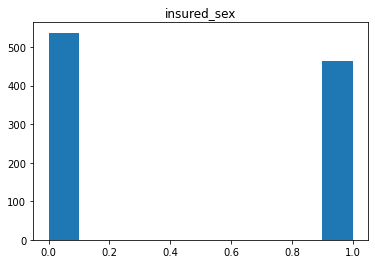

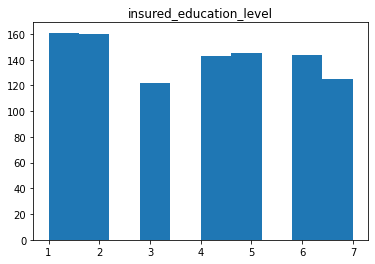

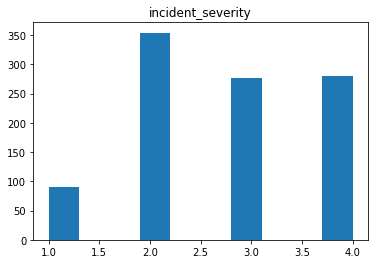

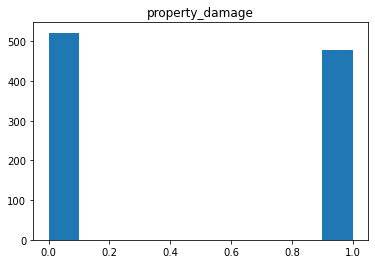

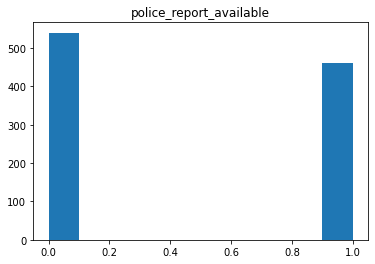

<Figure size 432x288 with 0 Axes>

In [30]:
for col in ['insured_sex','insured_education_level','incident_severity','property_damage','police_report_available']:
    plt.hist(data_imputed[col])
    plt.title(col)
    plt.show()
    plt.clf()


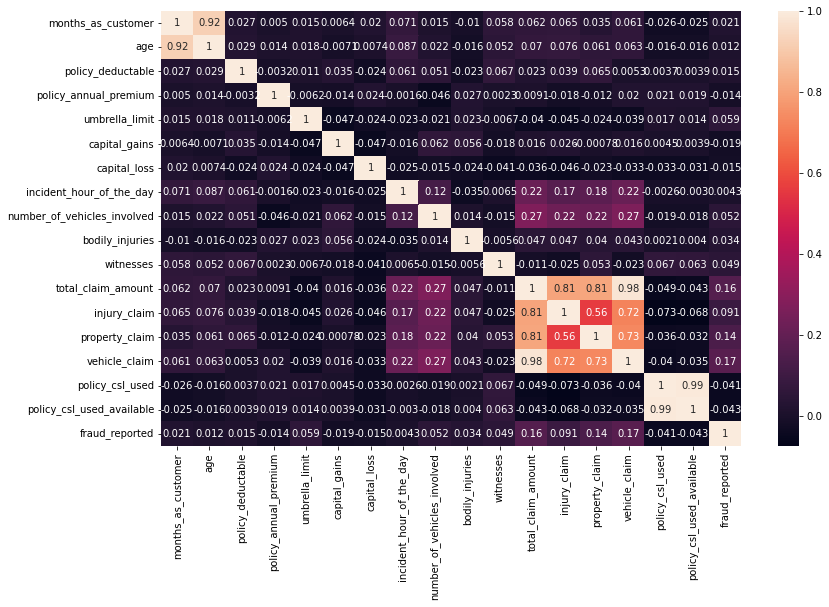

In [31]:
num_cols.append('fraud_reported')
plt.figure(figsize=(13,8))
sns.heatmap(data_imputed[num_cols].corr(), annot=True )

In [32]:
data_imputed.drop(columns = ['age','total_claim_amount'], inplace = True)

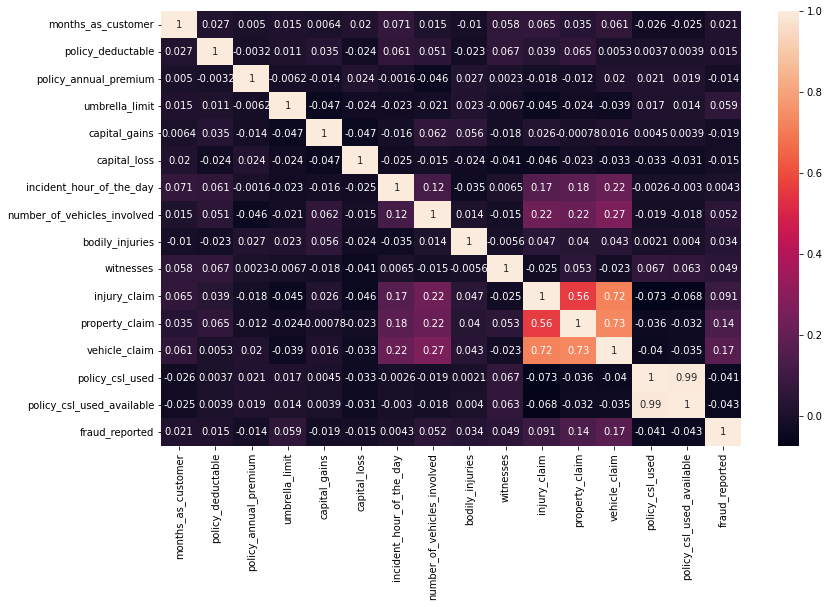

In [33]:
num_cols.remove('age')
num_cols.remove('total_claim_amount')
plt.figure(figsize=(13,8))
sns.heatmap(data_imputed[num_cols].corr(), annot=True )

##### Train Test Split

In [34]:
from sklearn.model_selection import train_test_split
X = data_imputed.drop('fraud_reported',axis=1)
y = data_imputed['fraud_reported']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

##### Scaling Data

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [37]:
MinMaxTransformer = MinMaxScaler()
MinMaxTransformer

MinMaxScaler()

In [38]:
X_Scaled = MinMaxTransformer.fit_transform(X)
X_Scaled = pd.DataFrame(data=X_Scaled, columns=X.columns,index=X.index)

In [39]:
from sklearn import svm
from sklearn.ensemble  import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

In [40]:
from sklearn.compose import ColumnTransformer
StandardTransformer = StandardScaler()
num_cols.remove('fraud_reported')
preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('std', StandardTransformer , num_cols),
            ('mm', MinMaxTransformer , ['insured_education_level','incident_severity','property_damage'])
        ])


In [41]:
X_Scaled = preprocessor.fit_transform(X)
X_Scaled = pd.DataFrame(X_Scaled, columns = X.columns)


In [42]:
num_cols

['months_as_customer',
 'policy_deductable',
 'policy_annual_premium',
 'umbrella_limit',
 'capital_gains',
 'capital_loss',
 'incident_hour_of_the_day',
 'number_of_vehicles_involved',
 'bodily_injuries',
 'witnesses',
 'injury_claim',
 'property_claim',
 'vehicle_claim',
 'policy_csl_used',
 'policy_csl_used_available']

In [43]:
X_Scaled

months_as_customer  policy_deductable  policy_annual_premium  \
0              1.078140          -0.222383               0.616705   
1              0.208995           1.412784              -0.242521   
2             -0.608002           1.412784               0.642233   
3              0.452355           1.412784               0.652886   
4              0.208995          -0.222383               1.341980   
..                  ...                ...                    ...   
995           -1.746582          -0.222383               0.222884   
996            0.704407          -0.222383               0.739141   
997           -0.642767          -1.039966               0.520739   
998            2.208028           1.412784               0.411866   
999            2.190645          -0.222383              -2.008710   

     umbrella_limit  insured_sex  insured_education_level  capital_gains  \
0         -0.479476     1.011331                 0.953851      -0.956261   
1          1.697980    -0.901927                 0.953851      -0.524475   
2          1.697980     0.358023                 0.953851      -0.668404   
3          2.133471     0.853388                -1.267577      -0.956261   
4          2.133471     1.467210                -0.683741       1.202666   
..              ...          ...                      ...            ...   
995       -0.479476    -0.901927                 0.953851       1.202666   
996       -0.479476     1.643100                 0.953851       1.634452   
997        0.826998     0.358023                 0.953851      -1.100189   
998        1.697980    -0.901927                 0.953851      -1.388046   
999       -0.479476    -0.901927                 0.953851      -0.812332   

     capital_loss  incident_severity  incident_hour_of_the_day  ...  \
0       -0.823865           0.009759                  0.461838  ...   
1       -0.823865          -1.210174                 -1.338700  ...   
2        1.140056           1.229693                  1.362107  ...   
3       -0.823865           0.009759                  0.461838  ...   
4       -0.823865          -1.210174                 -0.438431  ...   
..            ...                ...                       ...  ...   
995     -0.823865          -1.210174                 -0.438431  ...   
996     -0.823865           1.229693                  1.362107  ...   
997      1.140056           1.229693                  1.362107  ...   
998     -0.823865          -1.210174                 -0.438431  ...   
999     -0.823865          -1.210174                  1.362107  ...   

     io_machine-op-inspct  io_other-service  io_priv-house-serv  \
0                     0.0               0.0                 0.0   
1                     1.0               0.0                 0.0   
2                     0.0               0.0                 0.0   
3                     0.0               0.0                 0.0   
4                     0.0               0.0                 0.0   
..                    ...               ...                 ...   
995                   0.0               0.0                 0.0   
996                   0.0               0.0                 0.0   
997                   0.0               0.0                 0.0   
998                   0.0               0.0                 0.0   
999                   0.0               0.0                 0.0   

     io_prof-specialty  io_protective-serv  io_sales  io_tech-support  \
0                  0.0                 0.0       0.0              0.0   
1                  0.0                 0.0       0.0              0.0   
2                  0.0                 0.0       1.0              0.0   
3                  0.0                 0.0       0.0              0.0   
4                  0.0                 0.0       1.0              0.0   
..                 ...                 ...       ...              ...   
995                0.0                 0.0       0.0              0.0   
996                1.

In [44]:
from sklearn.model_selection import GridSearchCV

print("Running KNN, SVM, Random Forest and Decision Tree Model")

model_params = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'params' : {
            'leaf_size': list(range(1,50)),
            'n_neighbors' : list(range(1,30)),
            'p': [1,2]
        }  
    }, 
    'Logistic Regression' : {
        'model': LogisticRegression(solver='liblinear'),
        'params': {
            'C': list(range(1,10))
        }
    },  
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': list(range(1,50))
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],  
            'splitter' : ['best','random'],
            'min_samples_leaf' : list(range(1,50))
        }
    },
    'SVM': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': list(range(1,20)),
            'kernel': ['rbf','linear']
        }  
    },
    'XG_Boost': {
        'model': XGBClassifier(),
        'params': { 'n_estimators' :  [10, 50, 100, 130], 
                    'criterion': ['gini', 'entropy'], 
                    'max_depth': range(2, 10, 1) }
        }  
}



scores = []

for model_name, mp in model_params.items():
    print('Running ' + model_name)
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_Scaled, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'best_estimators' : clf.best_estimator_
    })
    
hyperparameter_tuning_results = pd.DataFrame(scores,columns=['model','best_score','best_params','best_estimators'])

print('Completed Generating Model Results')

hyperparameter_tuning_results.head(10)

Running KNN, SVM, Random Forest and Decision Tree Model
Running KNN
Running Logistic Regression
Running Random Forest
Running Decision Tree
Running SVM
Running XG_Boost
[16:40:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } mi

[16:40:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not use


[16:40:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 


[16:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

[16:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not use

[16:40:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not use

[16:40:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not use


[16:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 


[16:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 


[16:40:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 


[16:40:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 


[16:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

[16:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not use

[16:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not use


[16:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 


[16:40:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

[16:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not use

[16:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not use

[16:41:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:41:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:41:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not use

[16:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not use


[16:41:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:41:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:41:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 


[16:41:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:41:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:41:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

[16:41:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:41:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:41:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not use


[16:41:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:41:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:41:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

model  best_score  \
0                  KNN       0.756   
1  Logistic Regression       0.743   
2        Random Forest       0.772   
3        Decision Tree       0.803   
4                  SVM       0.753   
5             XG_Boost       0.798   

                                         best_params  \
0        {'leaf_size': 1, 'n_neighbors': 23, 'p': 1}   
1                                           {'C': 2}   
2                               {'n_estimators': 23}   
3  {'criterion': 'entropy', 'min_samples_leaf': 3...   
4                          {'C': 1, 'kernel': 'rbf'}   
5  {'criterion': 'gini', 'max_depth': 2, 'n_estim...   

                                     best_estimators  
0  KNeighborsClassifier(leaf_size=1, n_neighbors=...  
1        LogisticRegression(C=2, solver='liblinear')  
2  (DecisionTreeClassifier(max_features='auto', r...  
3  DecisionTreeClassifier(criterion='entropy', mi...  
4                             SVC(C=1, gamma='auto')  
5  XGBClassifier(base_score=0.5, booster='gbtree'...

In [45]:
hyperparameter_tuning_results.to_csv('model_hyperparameter_tuning_results.csv')